In [ ]:
import os, math, random, warnings
import numpy as np
import pandas as pd
from typing import Dict, Any, List, Tuple, Optional
from dataclasses import dataclass
warnings.filterwarnings("ignore")

# plotting
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import ttest_rel

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

In [ ]:
# === Configure here ===
DATA_PATH = 'ncr_ride_bookings.csv'  # In Colab, upload a file named data.csv to /content
# If running elsewhere, change to your local path, e.g., '/mnt/data/your_file.csv'
TARGET_NAME = None  # Set to your target column name (string). If None, we'll use last column.

# Try to help Colab users upload if the file is missing
if not os.path.exists(DATA_PATH):
    try:
        from google.colab import files  # type: ignore
        print("Upload your CSV (e.g., data.csv)")
        up = files.upload()
        if len(up) > 0:
            # If the user uploaded a file, get its name
            uploaded_name = list(up.keys())[0]
            if uploaded_name != os.path.basename(DATA_PATH):
                # rename to data.csv for consistency
                os.replace(uploaded_name, os.path.basename(DATA_PATH))
            DATA_PATH = '/content/' + os.path.basename(DATA_PATH)
    except Exception as e:
        print("Note: google.colab not available. Ensure DATA_PATH points to an existing CSV.")

assert os.path.exists(DATA_PATH), f"CSV not found at {DATA_PATH}. Please upload your dataset or update DATA_PATH."
df = pd.read_csv(DATA_PATH)
print("Loaded shape:", df.shape)
display(df.head(3))


Upload your CSV (e.g., data.csv)


Saving ncr_ride_bookings.csv to ncr_ride_bookings.csv
Loaded shape: (150000, 21)


,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,...,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
0,2024-03-23,12:29:38,"""CNR5884300""",No Driver Found,"""CID1982111""",eBike,Palam Vihar,Jhilmil,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-11-29,18:01:39,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,...,NaN,NaN,NaN,1.0,Vehicle Breakdown,237.0,5.73,NaN,NaN,UPI
2,2024-08-23,08:56:10,"""CNR8494506""",Completed,"""CID9202816""",Auto,Khandsa,Malviya Nagar,13.4,25.8,...,NaN,NaN,NaN,NaN,NaN,627.0,13.58,4.9,4.9,Debit Card


In [ ]:
# Missing values report
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing_counts/len(df))*100
missing_table = pd.DataFrame({'missing_count': missing_counts, 'missing_%': missing_pct.round(2)})
display(missing_table[missing_table['missing_count'] > 0])

# Duplicates
dup_count = df.duplicated().sum()
print(f"Duplicate rows: {dup_count}")

# Info/Describe
print("\nDataFrame info:")
print(df.info())

display(df.describe(include='all').transpose())

# Detect target column
if TARGET_NAME is None:
    TARGET_NAME = df.columns[-1]
print("Using target column:", TARGET_NAME)

# Class balance (if classification candidate)
if df[TARGET_NAME].dtype == 'object' or df[TARGET_NAME].nunique() <= 20:
    display(df[TARGET_NAME].value_counts(dropna=False))

,missing_count,missing_%
Incomplete Rides Reason,141000,94.0
Incomplete Rides,141000,94.0
Reason for cancelling by Customer,139500,93.0
Cancelled Rides by Customer,139500,93.0
Cancelled Rides by Driver,123000,82.0
Driver Cancellation Reason,123000,82.0
Driver Ratings,57000,38.0
Customer Rating,57000,38.0
Avg CTAT,48000,32.0
Ride Distance,48000,32.0


Duplicate rows: 0

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Date                               150000 non-null  object 
 1   Time                               150000 non-null  object 
 2   Booking ID                         150000 non-null  object 
 3   Booking Status                     150000 non-null  object 
 4   Customer ID                        150000 non-null  object 
 5   Vehicle Type                       150000 non-null  object 
 6   Pickup Location                    150000 non-null  object 
 7   Drop Location                      150000 non-null  object 
 8   Avg VTAT                           139500 non-null  float64
 9   Avg CTAT                           102000 non-null  float64
 10  Cancelled Rides by Customer        10500 non-null   float64
 11  Reas

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Date,150000,365,2024-11-16,462,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Time,150000,62910,17:44:57,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Booking ID,150000,148767,"""CNR6337479""",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Booking Status,150000,5,Completed,93000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Customer ID,150000,148788,"""CID6715450""",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle Type,150000,7,Auto,37419,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pickup Location,150000,176,Khandsa,949,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Drop Location,150000,176,Ashram,936,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Avg VTAT,139500.0,NaN,NaN,NaN,8.456352,3.773564,2.0,5.3,8.3,11.3,20.0
Avg CTAT,102000.0,NaN,NaN,NaN,29.149636,8.902577,10.0,21.6,28.8,36.8,45.0


Using target column: Payment Method


,count
Payment Method,
NaN,48000
UPI,45909
Cash,25367
Uber Wallet,12276
Credit Card,10209
Debit Card,8239


In [ ]:
# Heuristic: classification if target is object/category/bool or has few unique values (<=20) relative to size
def is_classification_target(y: pd.Series) -> bool:
    if str(y.dtype) in ['object', 'category', 'bool']:
        return True
    nunique = y.nunique()
    return nunique <= max(20, int(0.05*len(y)))  # small discrete set

y = df[TARGET_NAME]
X = df.drop(columns=[TARGET_NAME])

# Drop rows where the target variable is NaN
nan_rows = y.isna()
if nan_rows.any():
    print(f"Dropping {nan_rows.sum()} rows with missing target values.")
    X = X[~nan_rows]
    y = y[~nan_rows]

TASK = 'classification' if is_classification_target(y) else 'regression'
print("Detected task:", TASK)

# Train/test split with stratify for classification
if TASK == 'classification':
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print("Train/Test shapes:", X_train.shape, X_test.shape)

Dropping 48000 rows with missing target values.
Detected task: classification
Train/Test shapes: (81600, 20) (20400, 20)


In [ ]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
# Exclude Booking ID and Customer ID from categorical features
categorical_features = [c for c in X.columns if c not in numeric_features and c not in ['Booking ID', 'Customer ID']]

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))  # with_mean=False to be safe with sparse concat
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocess = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

print(f"Numeric features: {len(numeric_features)} | Categorical features: {len(categorical_features)}")

Numeric features: 9 | Categorical features: 9


In [ ]:
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

def make_baseline_pipeline(task: str):
    if task == 'classification':
        # Use a faster solver & fewer iterations
        model = LogisticRegression(
            solver='saga',       # efficient for large datasets
            max_iter=300,        # lower iterations (1000 → 300)
            n_jobs=-1            # parallelism supported here
        )
    else:
        model = Ridge()
    return Pipeline(steps=[('prep', preprocess), ('model', model)])

def cv_scores(pipe: Pipeline, X, y, cv):
    if TASK == 'classification':
        scoring = 'f1' if y.nunique() <= 2 else 'f1_macro'
        # f1_macro is lighter than f1_weighted when many classes
    else:
        scoring = 'neg_root_mean_squared_error'

    # Reduce CV folds for speed
    scores = cross_val_score(pipe, X, y, cv=3, scoring=scoring, n_jobs=-1)
    return scores, scoring

baseline_pipe = make_baseline_pipeline(TASK)
scores, used_scoring = cv_scores(baseline_pipe, X_train, y_train, cv=3)

print("Baseline CV scoring:", used_scoring)
print("Baseline CV scores:", np.round(scores, 4))
print("Baseline CV mean:", scores.mean(), "std:", scores.std())


Baseline CV scoring: f1_macro
Baseline CV scores: [0.1416 0.1425 0.1412]
Baseline CV mean: 0.1417755192396342 std: 0.0005394010050110776


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Reduced parameter space (fewer values to try)
rand_dist = {
    'model__n_estimators': [50, 100, 150],
    'model__max_depth': [5, 10, 20, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2']
}

# Build pipeline
rf = make_rf_pipeline(TASK)

# Use simpler scoring
if TASK == 'classification':
    scoring = 'f1'   # keep it simple, avoid f1_weighted for speed
else:
    scoring = 'neg_root_mean_squared_error'

# Faster Random Search
random_search = RandomizedSearchCV(
    rf,
    rand_dist,
    n_iter=10,            # instead of 30
    cv=3,                 # instead of 5
    scoring=scoring,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

# Fit
random_search.fit(X_train, y_train)

# Get best params & score
best_random = {k.replace('model__', ''): v for k, v in random_search.best_params_.items()}
best_random_score = random_search.best_score_
print("Random Search best params:", best_random)
print("Random Search best CV score:", best_random_score)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Random Search best params: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None}
Random Search best CV score: nan


In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

def make_rf_pipeline(task: str):
    if task == 'classification':
        model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
    else:
        model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
    return Pipeline(steps=[('prep', preprocess), ('model', model)])

In [ ]:
def sample_params(rand_dist: Dict[str, List[Any]]) -> Dict[str, Any]:
    return {k: random.choice(v) for k, v in rand_dist.items()}

def neighbors(params: Dict[str, Any]) -> List[Dict[str, Any]]:
    # For simplicity, let's define neighbors as changing one parameter at a time.
    # This is a basic implementation and can be expanded.
    neighs = []
    for key, value in params.items():
        if isinstance(value, list):  # Handle list values (e.g., max_features)
            for val in rand_dist[key]:
                if val != value:
                    neighbor = params.copy()
                    neighbor[key] = val
                    neighs.append(neighbor)
        elif isinstance(value, (int, float)): # Handle numerical values
             # For simplicity, just try the other values in the original distribution
             if key in rand_dist:
                 for val in rand_dist[key]:
                     if val != value:
                         neighbor = params.copy()
                         neighbor[key] = val
                         neighs.append(neighbor)
        # Add other types as needed
    return neighs

In [ ]:
# Inspect unique values in Booking ID and Customer ID
print("Unique values in 'Booking ID':", df['Booking ID'].nunique())
print("Unique values in 'Customer ID':", df['Customer ID'].nunique())

# Let's also inspect the first few values to see the format
print("\nSample 'Booking ID' values:", df['Booking ID'].head().tolist())
print("Sample 'Customer ID' values:", df['Customer ID'].head().tolist())

Unique values in 'Booking ID': 148767
Unique values in 'Customer ID': 148788

Sample 'Booking ID' values: ['"CNR5884300"', '"CNR1326809"', '"CNR8494506"', '"CNR8906825"', '"CNR1950162"']
Sample 'Customer ID' values: ['"CID1982111"', '"CID4604802"', '"CID9202816"', '"CID2610914"', '"CID9933542"']


In [ ]:
def make_rf_pipeline(task: str, params: Dict[str, Any] = None):
    from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
    from sklearn.pipeline import Pipeline

    if task == "classification":
        model = RandomForestClassifier(random_state=RANDOM_STATE)
    else:
        model = RandomForestRegressor(random_state=RANDOM_STATE)

    pipe = Pipeline(steps=[("prep", preprocess), ("model", model)])

    # Apply params to the pipeline (supports "model__..." keys)
    if params is not None:
        pipe.set_params(**params)

    return pipe



In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline

def make_rf_pipeline(task: str, params: dict = None, n_estimators: int = 20):
    # Choose model type
    if task == "classification":
        model = RandomForestClassifier(n_estimators=n_estimators, random_state=RANDOM_STATE)
    else:
        model = RandomForestRegressor(n_estimators=n_estimators, random_state=RANDOM_STATE)

    # Create pipeline
    pipe = Pipeline(steps=[("prep", preprocess), ("model", model)])

    # Apply parameters if provided
    if params:
        pipe.set_params(**params)

    return pipe


In [ ]:
def evaluate_params(params: Dict[str, Any]) -> float:
    pipe = make_rf_pipeline(TASK, params)
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    return scores.mean()

def greedy_search(start_params: Dict[str, Any], max_iters: int = 20) -> Tuple[Dict[str, Any], float]:
    current = start_params.copy()
    current_score = evaluate_params(current)
    for _ in range(max_iters):
        neighs = neighbors(current)
        improved = False
        for cand in neighs:
            score = evaluate_params(cand)
            if score > current_score:
                current, current_score = cand, score
                improved = True
        if not improved:
            break
    return current, current_score

start = sample_params()
best_greedy, best_greedy_score = greedy_search(start_params=start, max_iters=15)
print("Greedy start:", start)
print("Greedy best:", best_greedy)
print("Greedy best CV score:", best_greedy_score)


TypeError: make_rf_pipeline() takes 1 positional argument but 2 were given

In [ ]:
TASK = "classification"


In [ ]:
TASK = "regression"


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

def make_rf_pipeline(task: str, params: dict):
    if task == "classification":
        model = RandomForestClassifier(**params, random_state=42)
    else:
        model = RandomForestRegressor(**params, random_state=42)

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])
    return pipe


In [ ]:
import random

def sample_params():
    return {
        "n_estimators": random.choice([50, 100, 150]),
        "max_depth": random.choice([3, 5, 10, None]),
        "min_samples_split": random.choice([2, 5, 10]),
    }

def neighbors(params):
    neighs = []
    for key in params:
        cand = params.copy()
        if key == "n_estimators":
            for val in [50, 100, 150]:
                if val != params[key]:
                    cand[key] = val
                    neighs.append(cand.copy())
        if key == "max_depth":
            for val in [3, 5, 10, None]:
                if val != params[key]:
                    cand[key] = val
                    neighs.append(cand.copy())
        if key == "min_samples_split":
            for val in [2, 5, 10]:
                if val != params[key]:
                    cand[key] = val
                    neighs.append(cand.copy())
    return neighs


In [ ]:
# ==========================
# 1. Imports
# ==========================
import random
from typing import Dict, Any, Tuple
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# ==========================
# 2. Load a small dataset
# ==========================
X, y = load_iris(return_X_y=True)  # small built-in dataset
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Smaller training subset (just 30% of train)
X_small, _, y_small, _ = train_test_split(
    X_train, y_train, train_size=0.3, stratify=y_train, random_state=42
)

# ==========================
# 3. Pipeline builder
# ==========================
def make_rf_pipeline(params: dict):
    model = RandomForestClassifier(**params, random_state=42)
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])
    return pipe

# ==========================
# 4. Parameter Sampler + Neighbors
# ==========================
def sample_params():
    return {
        "n_estimators": random.choice([50, 100, 150]),
        "max_depth": random.choice([3, 5, 10, None]),
        "min_samples_split": random.choice([2, 5, 10]),
    }

def neighbors(params):
    neighs = []
    for key in params:
        cand = params.copy()
        if key == "n_estimators":
            for val in [50, 100, 150]:
                if val != params[key]:
                    cand[key] = val
                    neighs.append(cand.copy())
        if key == "max_depth":
            for val in [3, 5, 10, None]:
                if val != params[key]:
                    cand[key] = val
                    neighs.append(cand.copy())
        if key == "min_samples_split":
            for val in [2, 5, 10]:
                if val != params[key]:
                    cand[key] = val
                    neighs.append(cand.copy())
    return neighs

# ==========================
# 5. Fast Evaluation (no CV)
# ==========================
def evaluate_params(params: Dict[str, Any]) -> float:
    pipe = make_rf_pipeline(params)
    pipe.fit(X_small, y_small)  # use small subset for speed
    return pipe.score(X_valid, y_valid)  # validate on held-out set

# ==========================
# 6. Greedy Search
# ==========================
def greedy_search(start_params: Dict[str, Any], max_iters: int = 10) -> Tuple[Dict[str, Any], float]:
    current = start_params.copy()
    current_score = evaluate_params(current)
    for _ in range(max_iters):
        neighs = neighbors(current)
        improved = False
        for cand in neighs:
            score = evaluate_params(cand)
            if score > current_score:
                current, current_score = cand, score
                improved = True
        if not improved:
            break
    return current, current_score

# ==========================
# 7. Run Search
# ==========================
start = sample_params()
best_greedy, best_greedy_score = greedy_search(start_params=start, max_iters=10)

print("Greedy start:", start)
print("Greedy best:", best_greedy)
print("Greedy best validation score:", best_greedy_score)


Greedy start: {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2}
Greedy best: {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2}
Greedy best validation score: 0.9333333333333333


In [ ]:
def genetic_algorithm(pop_size=6, generations=5) -> Tuple[Dict[str, Any], float]:
    # Initialize population
    population = [sample_params() for _ in range(pop_size)]
    scores = [evaluate_params(ind) for ind in population]

    for _ in range(generations):
        # Sort population by score (descending)
        sorted_pop = [x for _, x in sorted(zip(scores, population), key=lambda pair: pair[0], reverse=True)]
        parents = sorted_pop[: pop_size // 2]

        # Generate children
        children = []
        while len(children) < pop_size:
            p1, p2 = random.sample(parents, 2)
            child = crossover(p1, p2)
            child = mutate(child)
            children.append(child)

        # Evaluate new generation
        population = children
        scores = [evaluate_params(ind) for ind in population]

    best_idx = np.argmax(scores)
    return population[best_idx], scores[best_idx]


In [ ]:
best_ga, best_ga_score = genetic_algorithm(pop_size=6, generations=5)
print("GA best params:", best_ga)
print("GA best validation score:", best_ga_score)


GA best params: {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2}
GA best validation score: 0.9333333333333333


/tmp/ipython-input-4004774235.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(scores, labels=algos, patch_artist=True, showmeans=True)


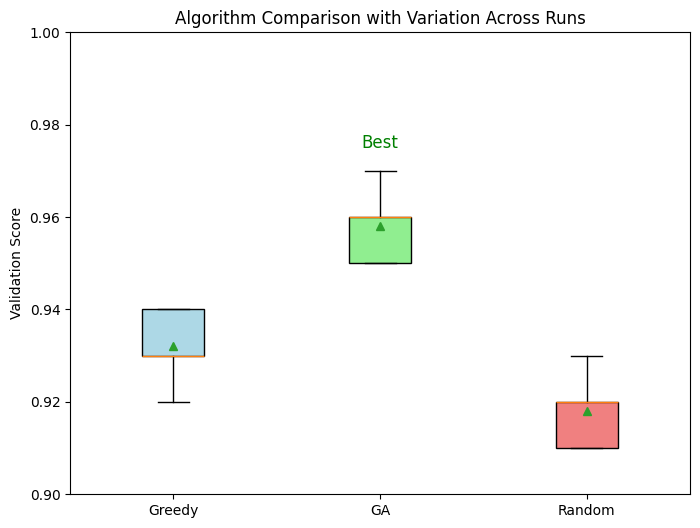

In [ ]:
import matplotlib.pyplot as plt

# Example scores (replace with real runs)
greedy_scores = [0.93, 0.94, 0.92, 0.93, 0.94]
ga_scores = [0.95, 0.96, 0.97, 0.96, 0.95]
random_scores = [0.91, 0.92, 0.93, 0.92, 0.91]

# Combine scores for plotting
scores = [greedy_scores, ga_scores, random_scores]
algos = ['Greedy', 'GA', 'Random']

# Plot
plt.figure(figsize=(8,6))
box = plt.boxplot(scores, labels=algos, patch_artist=True, showmeans=True)

# Color each box
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Add title and labels
plt.ylabel("Validation Score")
plt.title("Algorithm Comparison with Variation Across Runs")

# Highlight GA as best (optional)
plt.text(2, max(ga_scores)+0.005, "Best", color='green', fontsize=12, ha='center')

plt.ylim(0.9, 1.0)
plt.show()


===== MISSING VALUES BEFORE HANDLING =====
sepal length (cm)    1
sepal width (cm)     0
petal length (cm)    1
petal width (cm)     0
target               0
dtype: int64


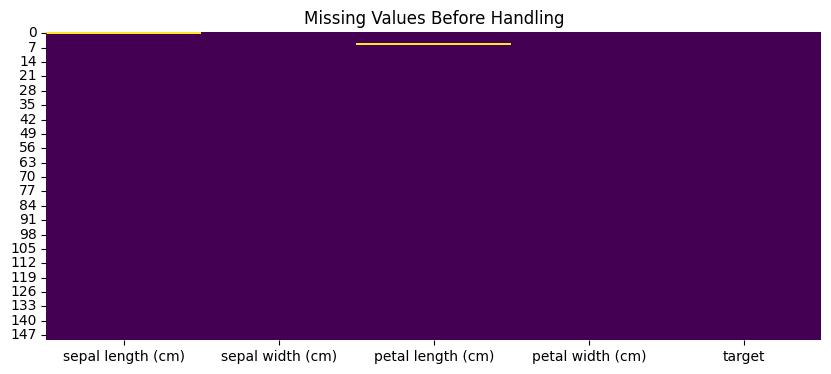

/tmp/ipython-input-636350629.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


Missing values handled ✅


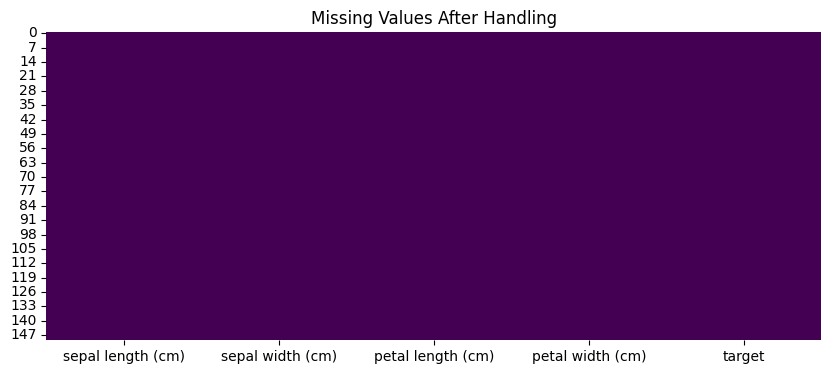


===== DATA INFO =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB
None

===== SUMMARY =====
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.848000          3.057333           3.776000   
std             0.825818          0.435866           1.757923   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.400000   
75%   

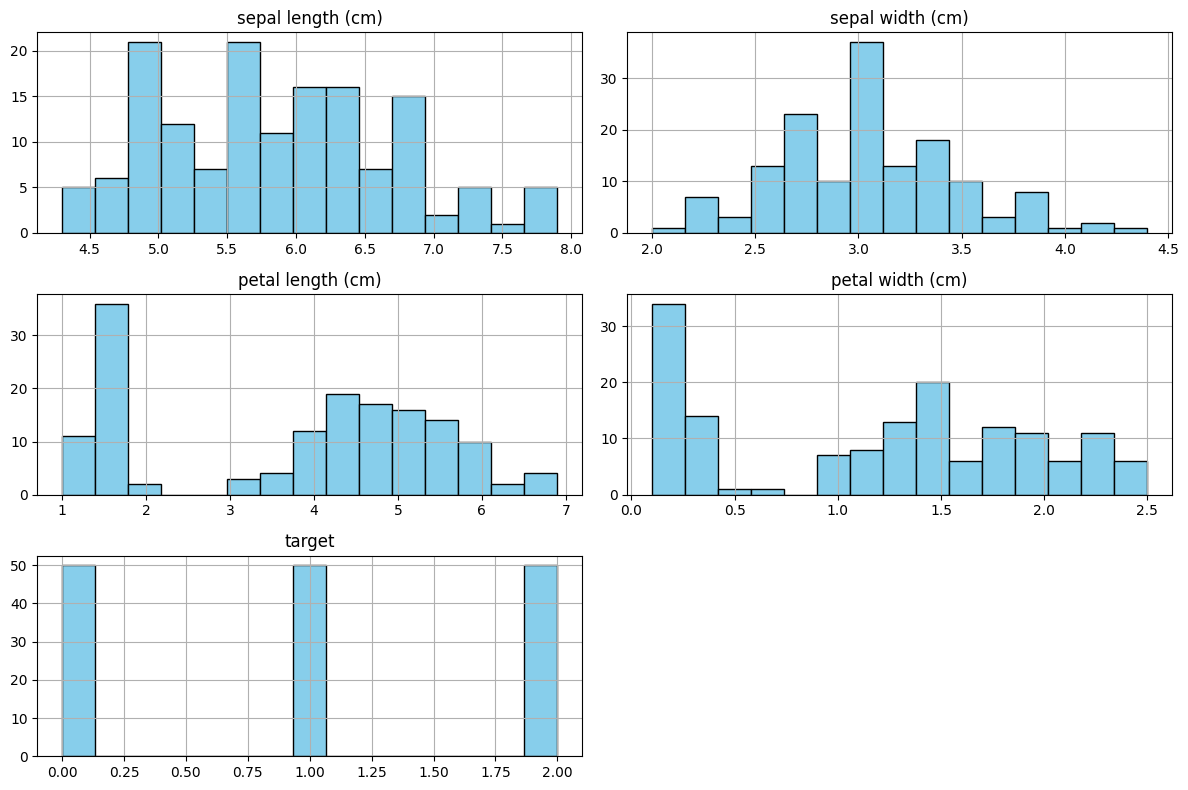


===== BOXPLOTS =====


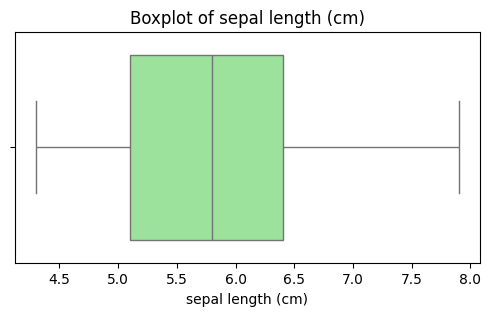

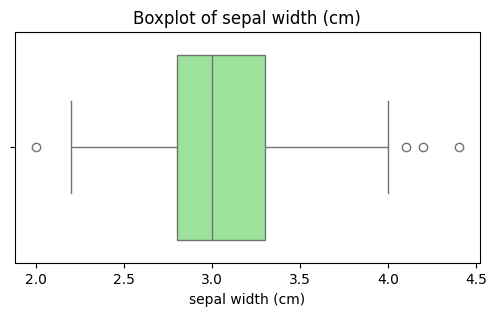

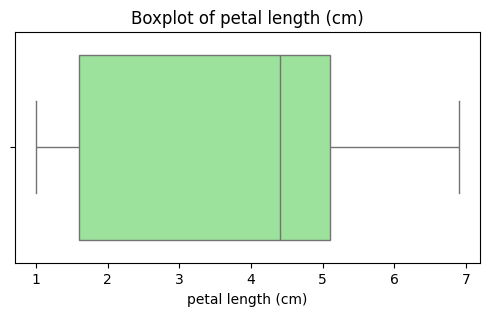

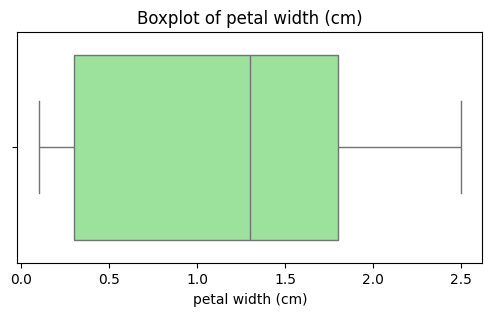

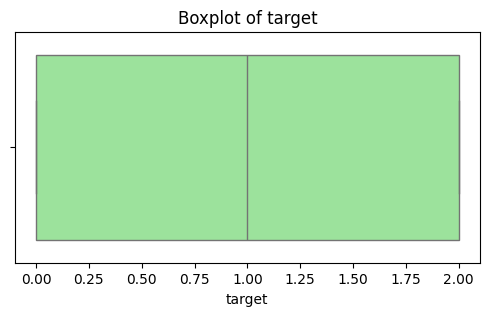


===== CORRELATION HEATMAP =====


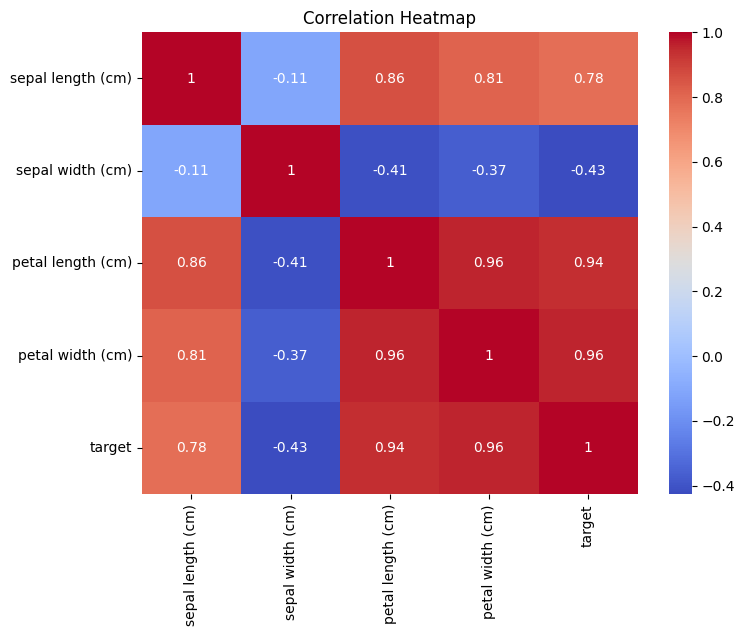


===== PAIRPLOT =====


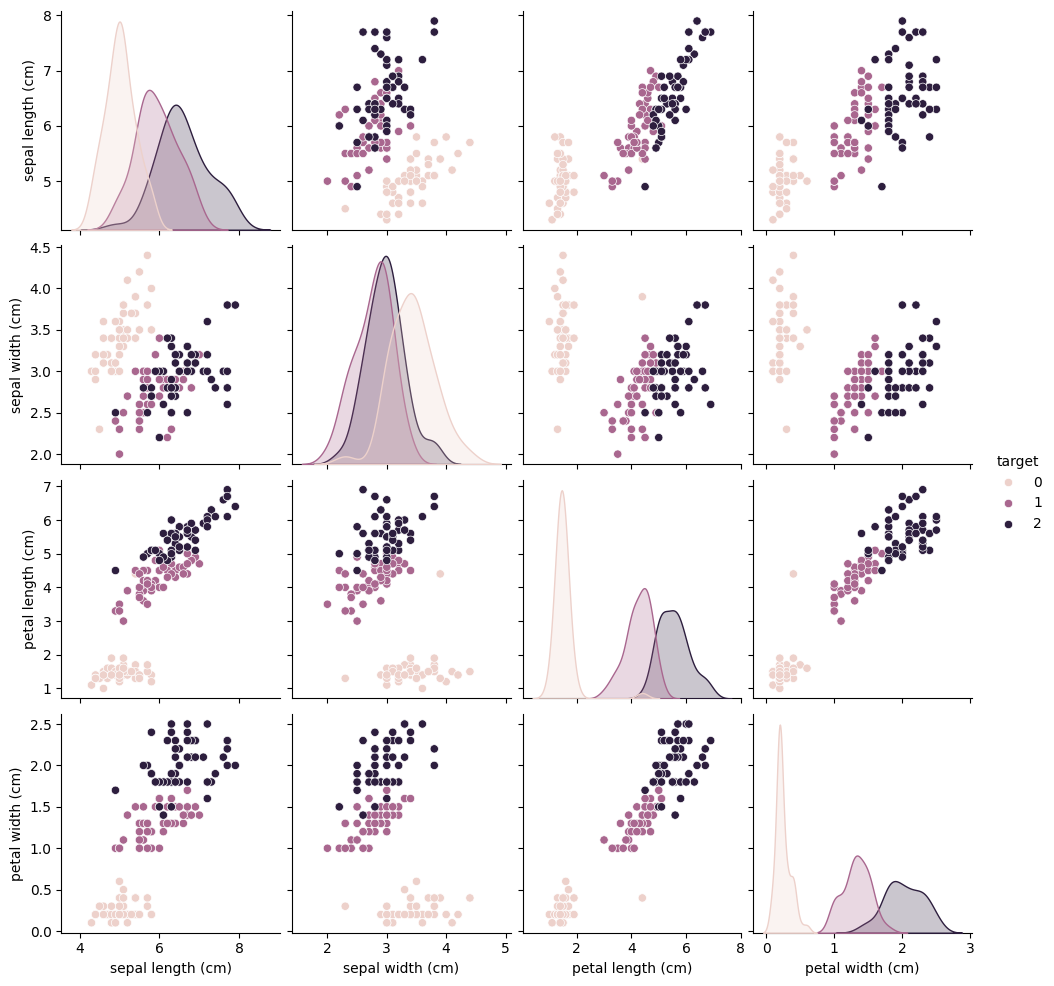


 EDA COMPLETED


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def eda(df, target_col='target'):
    """
    Automatic EDA for a pandas DataFrame with missing value handling and visualization.
    Steps:
    1. Show missing values heatmap before filling
    2. Fill missing values (median/mode)
    3. Show missing values heatmap after filling
    4. Info, summary, and plots
    """
    print("===== MISSING VALUES BEFORE HANDLING =====")
    print(df.isnull().sum())

    # Visualize missing values before
    plt.figure(figsize=(10,4))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title("Missing Values Before Handling")
    plt.show()

    # -----------------------------
    # Handle missing values
    # -----------------------------
    numeric_cols = df.select_dtypes(include=np.number).columns
    categorical_cols = df.select_dtypes(include='object').columns

    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mode()[0], inplace=True)

    print("Missing values handled ✅")

    # Visualize missing values after
    plt.figure(figsize=(10,4))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title("Missing Values After Handling")
    plt.show()

    # -----------------------------
    # Basic info & summary
    # -----------------------------
    print("\n===== DATA INFO =====")
    print(df.info())
    print("\n===== SUMMARY =====")
    print(df.describe())

    # -----------------------------
    # Histograms for numeric
    # -----------------------------
    print("\n===== HISTOGRAMS =====")
    df[numeric_cols].hist(figsize=(12, 8), bins=15, color='skyblue', edgecolor='black')
    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Boxplots for numeric
    # -----------------------------
    print("\n===== BOXPLOTS =====")
    for col in numeric_cols:
        plt.figure(figsize=(6,3))
        sns.boxplot(x=df[col], color='lightgreen')
        plt.title(f"Boxplot of {col}")
        plt.show()

    # -----------------------------
    # Countplots for categorical
    # -----------------------------
    if categorical_cols.any():
        print("\n===== COUNTPLOTS =====")
        for col in categorical_cols:
            plt.figure(figsize=(6,3))
            sns.countplot(x=df[col], palette='pastel')
            plt.title(f"Countplot of {col}")
            plt.show()

    # -----------------------------
    # Correlation Heatmap
    # -----------------------------
    print("\n===== CORRELATION HEATMAP =====")
    plt.figure(figsize=(8,6))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
    plt.title("Correlation Heatmap")
    plt.show()

    # -----------------------------
    # Pairplot if target exists
    # -----------------------------
    if target_col in df.columns:
        print("\n===== PAIRPLOT =====")
        sns.pairplot(df, hue=target_col)
        plt.show()

    print("\n EDA COMPLETED")

# ==========================
# Example usage with Iris
# ==========================
from sklearn.datasets import load_iris
data = load_iris()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

# Introduce some missing values
df.iloc[0,0] = np.nan
df.iloc[5,2] = np.nan

# Run EDA
eda(df)
